## Итак что у нас есть:

* ### Тренировочные данные состоят из 323 наблюдений, в каждом из которых есть 40 сигналов датчиков снятые 100 раз с равными промежутками времени (на вскидку всё наблюдение это 100 миллисекунд)

* ### Тренировочные данные получены следующим образомЖ пилоту показываю жест - пилот повторяет жест (всё это время датчики регистрирую какие-то параметры) логично, что между командой на выполнение жеста и самим жестом проходит како-то время ($\Delta t$) 

## Содержание <a class="anchor" id=0></a>

1. [Вариант 1 - Грубый time_shift, f1-score:0.950037](#1)
2. [Вариант 2 - Ведём состояние покоя на каждый датчик](#2)
3. [Вариант 3 - LightGBM f1-score: `0.95814`](#3)
4. [Вариант 4 - Последняя надежда](#4)
5. [Vizualization part](#5)


***
## Вариант 1 RandomForestClassifier: 0.950037<a class="anchor" id=1></a>

[к содержанию](#0)

### Попробум грубо компенсировать $\Delta t$ и выполнить предсказания используя `RandomForestClassifier`

# Read data

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

import optuna

In [2]:
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')

data_y_train = pd.read_csv('y_train.csv')
#y_test = pd.read_csv('y_test.csv')
data_y_test = pd.read_csv('sample_submission.csv')

print(data_train.shape, data_y_train.shape)
print(data_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


In [391]:
# Определим функцию сдвигателя показаний на заданный временной интервал
def shifter(data, n=20):
    lst = list(data)
    for i in range(n):
        lst.insert(0, i*0)
        lst.pop(-1)
       
    return lst

In [392]:
data_y_train['class'] = shifter(data_y_train['class'])

In [393]:
data_y_train[['sample_id', 'timestep']] = data_y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_train = data_y_train.pivot(index='sample_id', columns='timestep', values='class')
data_y_train_index = data_y_train.index
data_y_train = data_y_train.sort_index() # на всякий случай
data_y_train = data_y_train.values

print(data_y_train.shape)
data_y_train

(323, 100)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 6, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

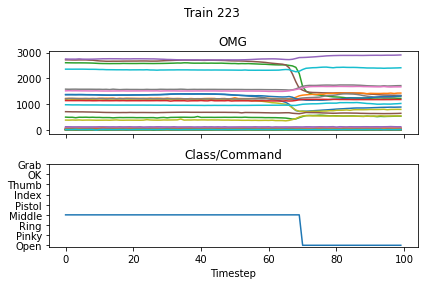

In [394]:
i = np.random.randint(data_y_train.shape[0])

fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(data_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(data_y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

In [395]:
# Подготовом данные к загрузке в модель
list_1 = []
list_2 = []
list_3 = []
list_4 = []

for i in range(data_train.shape[0]):
    list_1.append(data_train[i].T)

arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
    list_2.extend(arr_1[i])

for i in range(data_test.shape[0]):
    list_3.append(data_test[i].T)

arr_2 = np.array(list_3)

for i in range(arr_2.shape[0]):
    list_4.extend(arr_2[i])
    
X = np.array(list_2)

X_sub = np.array(list_4)

X.shape, X_sub.shape

((32300, 40), (5400, 40))

In [396]:
df_y_train = []
for idx, arr in zip(data_y_train_index, data_y_train):
    
    series = pd.Series(arr)
    series.index = [f"{idx}-{i}" for i in series.index]
    df_y_train.append(series)
    
df_y_train = pd.concat(df_y_train)
df_y_train = df_y_train.reset_index()
df_y_train.columns = ["sample-timestep", "class"]
df_y_train

y = df_y_train.drop('sample-timestep', axis=1)
y = np.array(y).ravel()

In [397]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(27455, 40) (27455,) (4845, 40) (4845,)


In [398]:
# Отмасштабируем данные
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_sub = scaler.transform(X_sub)

In [399]:
# Попробуем несколько классификаторов (с настройками по умолчанию)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

RFC = RandomForestClassifier(random_state=42)


RFC.fit(X_train, y_train)


y_train_pred_rfc = RFC.predict(X_train)
y_valid_pred_rfc = RFC.predict(X_valid)


print('\nRandomForestClassifier')
print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred_rfc, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred_rfc, average="macro")))



RandomForestClassifier
F-1 score on train: 1.000000
F-1 score on valid: 0.981727


### Попробуем подобрать гиперпараметры и маленько улучшить целевую метрику

In [400]:
# Подберём гиперпараметры 
import optuna
def optuna_rfc(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 70, 570, 1)
  max_depth = trial.suggest_int('max_depth', 10, 50, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 6, 1)

  # создаем модель
  model_op = RandomForestClassifier(n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    criterion='entropy',
                                    random_state=42)
  # обучаем модель
  model_op.fit(X_train, y_train)
  score = metrics.f1_score(y_valid, model_op.predict(X_valid), average="macro")

  return score

In [172]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rfc, n_trials=10)

[I 2023-04-20 09:15:02,966] A new study created in memory with name: RandomForestClassifier
[I 2023-04-20 09:15:35,122] Trial 0 finished with value: 0.9470760208049656 and parameters: {'n_estimators': 403, 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9470760208049656.
[I 2023-04-20 09:16:11,830] Trial 1 finished with value: 0.9529253108592558 and parameters: {'n_estimators': 445, 'max_depth': 49, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9529253108592558.
[I 2023-04-20 09:16:29,161] Trial 2 finished with value: 0.9415592337129337 and parameters: {'n_estimators': 259, 'max_depth': 11, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9529253108592558.
[I 2023-04-20 09:16:41,595] Trial 3 finished with value: 0.9469298313343959 and parameters: {'n_estimators': 157, 'max_depth': 35, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9529253108592558.
[I 2023-04-20 09:16:57,784] Trial 4 finished with value: 0.9422658349754703 and parameters: {'n_

CPU times: total: 3min 49s
Wall time: 3min 50s


In [189]:
study.optimize(optuna_rfc, n_trials=2)

[I 2023-04-20 09:56:03,469] Trial 31 finished with value: 0.9558151417366739 and parameters: {'n_estimators': 284, 'max_depth': 25, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:56:22,378] Trial 32 finished with value: 0.9563173520698006 and parameters: {'n_estimators': 221, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:56:49,828] Trial 33 finished with value: 0.9530281916106154 and parameters: {'n_estimators': 326, 'max_depth': 23, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:57:12,239] Trial 34 finished with value: 0.9558067503530621 and parameters: {'n_estimators': 263, 'max_depth': 31, 'min_samples_leaf': 2}. Best is trial 21 with value: 0.95652169431791.
[I 2023-04-20 09:57:31,533] Trial 35 finished with value: 0.9525467827719503 and parameters: {'n_estimators': 231, 'max_depth': 34, 'min_samples_leaf': 3}. Best is trial 21 with value: 0.9

In [193]:
# выводим результаты на обучающей выборке

#best_param = (n_estimators=192,max_depth=28,min_samples_leaf=2,criterion='entropy', random_state=42    )

print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на валидационном наборе: {:.5f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 192, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на валидационном наборе: 0.95652


In [401]:
rf_opt = RandomForestClassifier(
    n_estimators=192,
    max_depth=28,
    min_samples_leaf=2,
    criterion='entropy', 
    random_state=42    
)

rf_opt.fit(X_train, y_train)

y_train_pred = rf_opt.predict(X_train)
y_valid_pred = rf_opt.predict(X_valid)

print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred, average="macro")))

F-1 score on train: 0.999275
F-1 score on valid: 0.982650


In [402]:
y_test_pred = rf_opt.predict(X_sub)

In [403]:
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_test_pred
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test['class'].value_counts()

0    3168
6     311
5     279
1     277
2     276
4     274
3     274
8     273
7     268
Name: class, dtype: int64

In [404]:
data_y_test.to_csv('sample_submission_v1.csv')

In [405]:
data_y_test.reset_index(inplace=True)
data_y_test[['sample_id', 'timestep']] = data_y_test['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_test = data_y_test.pivot(index='sample_id', columns='timestep', values='class')
data_y_test_index = data_y_test.index
data_y_test = data_y_test.sort_index() # на всякий случай
data_y_test = data_y_test.values

print(data_y_test.shape)
data_y_test

(54, 100)


array([[4, 4, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

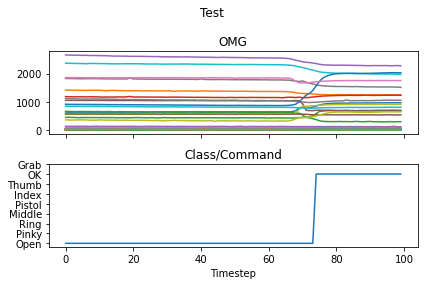

In [411]:
i = np.random.randint(data_y_test.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(data_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(data_y_test[i])

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()

***
## Вариант 2 <a class="anchor" id=2></a>

[к содержанию](#0)


In [412]:
# Определим функцию сдвигателя показаний на заданный временной интервал
def shifter(data, n=20):
    """_сдвигатель_
    """
    lst = list(data)
    for i in range(n):
        lst.insert(0, i*0)
        lst.pop(-1)
       
    return lst

In [413]:
def trending(data, n=0.082222):
    """_сглаживатель_
    """
    trend_list = []
    data_0 = data[0]
    delta = data_0 * n
    for i in range(len(data)-1):
        if abs(data[i] - data_0) < delta:
            trend_list.append(data_0)
        else:
            data_0 = data[i]
            trend_list.append(data_0)
    
    trend_list.append(data_0)    
        
    return trend_list

In [414]:
def add_trend(data, n=0.082222):
    """_применятель сглаживателя_
    """
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data[i][j,:] = trending(data[i][j,:], n)
    return data

In [415]:
def shifter_for_y(data, n=20):
    lst = list(data)
    for i in range(n):
        lst.insert(0, i*0)
        lst.pop(-1)
       
    return lst

In [416]:
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')
data_y_train = pd.read_csv('y_train.csv')

data_y_train['class'] = shifter(data_y_train['class'])

data_y_train[['sample_id', 'timestep']] = data_y_train['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_train = data_y_train.pivot(index='sample_id', columns='timestep', values='class')
data_y_train_index = data_y_train.index
data_y_train = data_y_train.sort_index() # на всякий случай
data_y_train = data_y_train.values



list_1 = []
list_2 = []
list_3 = []
list_4 = []

for i in range(data_train.shape[0]):
    list_1.append(data_train[i].T)

    arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
    list_2.extend(arr_1[i])

for i in range(data_test.shape[0]):
    list_3.append(data_test[i].T)

    arr_2 = np.array(list_3)

for i in range(arr_2.shape[0]):
    list_4.extend(arr_2[i])
            
    X = np.array(list_2)

    X_sub = np.array(list_4)
 
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.15, 
    random_state=42
)

scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_sub = scaler.transform(X_sub)
X = scaler.transform(X)
                               
RFC = RandomForestClassifier(
                n_estimators=192,
                max_depth=28,
                min_samples_leaf=2,
                criterion='entropy', 
                random_state=42    
            )

RFC.fit(X_train, y_train)
    
y_train_pred_rfc = RFC.predict(X_train)
y_valid_pred_rfc = RFC.predict(X_valid)

print('\nRandomForestClassifier')
print('F-1 score on train: {:.6f}'.format(metrics.f1_score(y_train, y_train_pred_rfc, average="macro")))
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y_valid, y_valid_pred_rfc, average="macro")))



RandomForestClassifier
F-1 score on train: 0.999275
F-1 score on valid: 0.982650


In [417]:
y_train_pred = RFC.predict(X)
y_sub_pred = RFC.predict(X_sub)
y_df = pd.DataFrame(y_train_pred)
y_df_sub = pd.DataFrame(y_sub_pred)
df_1 = pd.get_dummies(y_df[0], dtype=float)
df_2 = pd.get_dummies(y_df_sub[0], dtype=float)
X_new = np.concatenate([X, np.array(df_1)], axis=1)
X_new_sub = np.concatenate([X_sub, np.array(df_2)], axis=1)
                          
RFC = RandomForestClassifier()

RFC.fit(X_new, y)   

y_valid_pred_rfc = RFC.predict(X_new)

print('\nRandomForestClassifier')
print('F-1 score on valid: {:.6f}'.format(metrics.f1_score(y, y_valid_pred_rfc, average="macro")))


RandomForestClassifier
F-1 score on valid: 1.000000


In [418]:
y_pred = RFC.predict(X_new_sub)
y_pred.mean()

1.8683333333333334

In [419]:
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_pred
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test['class'].value_counts()
data_y_test.to_csv('sample_submission_v2.csv')

***
## Вариант 3 LightGBM <a class="anchor" id=3></a>

[к содержанию](#0)

In [4]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [5]:
def shifter(data, n=20):
    """_сдвигатель ряда на определённый шаг_

    Args:
        data (_array_): _массив который двигаем_
        n (int, optional): _шаг_. Defaults to 20.

    Returns:
        _array_: _массив каждый эленет которого сдвинут влево_
    """
    lst = list(data)
    for i in range(n):
        lst.insert(0, i*0)
        lst.pop(-1)
       
    return lst

In [6]:
# Загружаем данные
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')
data_y_train = pd.read_csv('y_train.csv')

# Скомпенсируем запаздывание пилота между принятием команды и её исполнением
data_y_train['class'] = shifter(data_y_train['class'],21)

# Подготовим вектор ответов
y = data_y_train.drop('sample-timestep', axis=1)
y = np.array(y).ravel()

# Выполнем корявую трансвормацию массивов из формата наблюдения-датчики-время в наблюдения*время-датчики
list_1 = []
list_2 = []
list_3 = []
list_4 = []

for i in range(data_train.shape[0]):
    list_1.append(data_train[i].T)

arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
    list_2.extend(arr_1[i])

for i in range(data_test.shape[0]):
    list_3.append(data_test[i].T)

arr_2 = np.array(list_3)

for i in range(arr_2.shape[0]):
    list_4.extend(arr_2[i])
    
X = np.array(list_2)
X_sub = np.array(list_4)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, 
    test_size=0.02, 
    random_state=42
)

# Отмасштабируем данные
scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_sub = scaler.transform(X_sub)
X = scaler.transform(X)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((31654, 40), (31654,), (646, 40), (646,))

In [7]:
X.shape

(32300, 40)

In [8]:
# Подготовом сеты данных
train_dataset = lgb.Dataset(X_train, y_train)
test_dataset = lgb.Dataset(X_valid, y_valid)

# потренируем модель
booster = lgb.train({"objective": "multiclass", "num_class":9, "verbosity": -1},
                    train_set=train_dataset, valid_sets=(test_dataset,),
                    num_boost_round=200)

# Сделаем предсказания
train_preds = booster.predict(X_train)
valid_preds = booster.predict(X_valid)
set_preds = booster.predict(X)

train_preds = np.argmax(train_preds, axis=1)
valid_preds = np.argmax(valid_preds, axis=1)
set_preds = np.argmax(set_preds, axis=1)

# Выведем метрику
print("\nTest F1: %.6f"%f1_score(y_train, train_preds, average="macro"))
print("Train F1: %.6f"%f1_score(y_valid, valid_preds, average="macro"))
print("Whole set F1: %.6f"%f1_score(y, set_preds, average="macro"))

[1]	valid_0's multi_logloss: 0.91773
[2]	valid_0's multi_logloss: 0.730579
[3]	valid_0's multi_logloss: 0.597222
[4]	valid_0's multi_logloss: 0.495633
[5]	valid_0's multi_logloss: 0.415575
[6]	valid_0's multi_logloss: 0.350781
[7]	valid_0's multi_logloss: 0.298812
[8]	valid_0's multi_logloss: 0.255528
[9]	valid_0's multi_logloss: 0.219335
[10]	valid_0's multi_logloss: 0.189093
[11]	valid_0's multi_logloss: 0.163693
[12]	valid_0's multi_logloss: 0.142919
[13]	valid_0's multi_logloss: 0.12421
[14]	valid_0's multi_logloss: 0.108925
[15]	valid_0's multi_logloss: 0.0964792
[16]	valid_0's multi_logloss: 0.0850427
[17]	valid_0's multi_logloss: 0.0760559
[18]	valid_0's multi_logloss: 0.0684438
[19]	valid_0's multi_logloss: 0.0620504
[20]	valid_0's multi_logloss: 0.0565198
[21]	valid_0's multi_logloss: 0.0517933
[22]	valid_0's multi_logloss: 0.0472976
[23]	valid_0's multi_logloss: 0.0431021
[24]	valid_0's multi_logloss: 0.0394263
[25]	valid_0's multi_logloss: 0.0367385
[26]	valid_0's multi_logl

In [330]:
# Выполним предсказания для тестовых данных
y_sub = booster.predict(X_sub)
y_sub = np.argmax(y_sub, axis=1)

In [499]:
# Запишем предсказания в требуемый Kaggle вид
data_y_test = pd.read_csv('sample_submission.csv')
data_y_test['class'] = y_sub
data_y_test.set_index('sample-timestep', inplace=True)
data_y_test.to_csv('sample_submission.csv')
data_y_test.reset_index(inplace=True)
data_y_test

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4


***
## Вариант 4 <a class="anchor" id=4></a>

[к содержанию](#0)

### Попробуем играть от ответов, выясним какие датчики наиболее сильно реагирует при каждом жесте.

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt

In [2]:
# Загружаем данные
data_train = np.load('X_train.npy')
data_test = np.load('X_test.npy')
data_y_train = pd.read_csv('y_train.csv')

# Подготовим вектор ответов
#y = data_y_train.drop('sample-timestep', axis=1)
#y = np.array(y).ravel()

list_1 = []
list_2 = []
list_3 = []
list_4 = []

for i in range(data_train.shape[0]):
    list_1.append(data_train[i].T)

arr_1 = np.array(list_1)

for i in range(arr_1.shape[0]):
    list_2.extend(arr_1[i])

for i in range(data_test.shape[0]):
    list_3.append(data_test[i].T)

arr_2 = np.array(list_3)

for i in range(arr_2.shape[0]):
    list_4.extend(arr_2[i])
    
X = np.array(list_2)
X_sub = np.array(list_4)

df_train = pd.DataFrame(X)
df_train = df_train.join(data_y_train, how='left')
df_train['sample'] = df_train['sample-timestep'].apply(lambda x: x.split('-', 1)[0]).astype(int)
df_train['time'] = df_train['sample-timestep'].apply(lambda x: x.split('-', 1)[1]).astype(int)

In [3]:
plot_data = df_train.groupby(by='class').mean()

(0.0, 175.0)

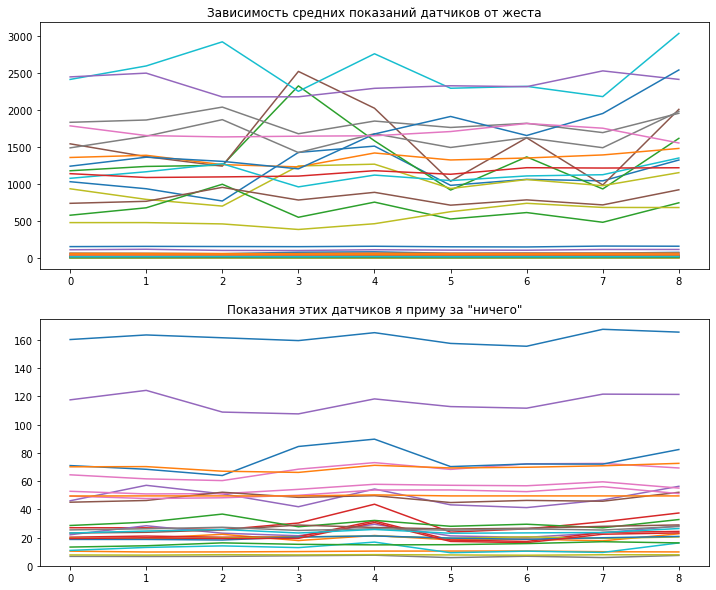

In [124]:
fig, axx = plt.subplots(2, 1, figsize=(12, 10))
axx[0].plot(plot_data)
axx[0].set_title('Зависимость средних показаний датчиков от жеста')

axx[1].plot(plot_data)
axx[1].set_title('Показания этих датчиков я приму за "ничего"')
axx[1].set_ylim(0,175)

In [68]:
col_to_drop = []
for i in np.arange(40):
    if plot_data[i].mean() < 200:
        col_to_drop.append(i)
        
len(col_to_drop)
df_train = df_train.drop(col_to_drop, axis=1)

In [69]:
df = df_train.drop(['sample-timestep', 'sample', 'time'], axis=1)

In [70]:
df.columns

Index([0, 2, 5, 8, 12, 15, 17, 19, 21, 24, 27, 29, 30, 33, 36, 38, 'class'], dtype='object')

In [ ]:
# Графическим методом выявим наиболее характерные датчики для каждого жеста
fig, axx = plt.subplots(2, 1, figsize=(7, 7))
axx[0].plot(df.groupby('class').mean()[36])
axx[0].set_title('Зависимость средних показаний датчиков от жеста')

axx[1].plot(df.groupby('class').mean()[24])

In [99]:
sensors = {
    '0':0,
    '1':24,
    '2':15,
    '3':2,
    '4':21,
    '5':30,
    '6':36,
    '7':24,
}
sens_list = list(sensors.values())
sens_list.extend(['time', 'class', 'sample'])

In [171]:
data = df_train[sens_list]

In [142]:
d_1 = data[data['sample'] == 4][[30, 'time', 'class']]

In [173]:
joined = data.join(data[[0, 24, 15, 2, 21, 30, 36]].pct_change(), how='left', lsuffix='prc')

In [185]:
joined = joined.fillna(0)
joined[['sample', 'time', 'class']][abs(joined['0']) > 0.10]

,sample,time,class
472,4,72,5
473,4,73,5
564,5,64,0
565,5,65,0
568,5,68,0
...,...,...,...
31973,319,73,0
31974,319,74,0
31975,319,75,0
32078,320,78,7


In [191]:
joined[joined['sample'] == 4][['30', 'class', 'time']]

,30,class,time
400,-0.004304,0,0
401,-0.002882,0,1
402,-0.000723,0,2
403,-0.000723,0,3
404,-0.000724,0,4
...,...,...,...
495,-0.000931,5,95
496,-0.000466,5,96
497,-0.002331,5,97
498,-0.001402,5,98


<AxesSubplot:xlabel='time', ylabel='30'>

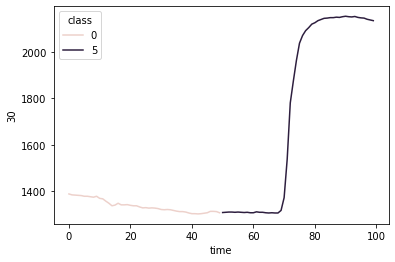

In [121]:
import seaborn as sns
sns.lineplot(data=data[data['sample'] == 4][[30, 'time', 'class']],
             x='time',
             y=30,
             hue='class')

***
## Vizualization part <a class="anchor" id=5></a>

[к содержанию](#0)

In [3]:
data_y_test[['sample_id', 'timestep']] = data_y_test['sample-timestep'].str.split('-', 1, expand=True).astype(int)
data_y_test = data_y_test.pivot(index='sample_id', columns='timestep', values='class')
data_y_test_index = data_y_test.index
data_y_test = data_y_test.sort_index() # на всякий случай
data_y_test = data_y_test.values

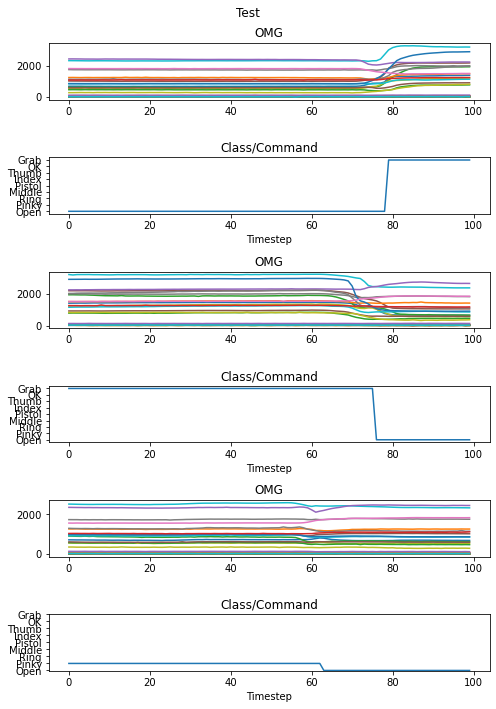

In [5]:
i = np.random.randint(data_y_test.shape[0])
fig, axx = plt.subplots(nrows=6, figsize=(7, 10))
    
axx[0].plot(data_test[i].T)
axx[0].set_title('OMG')

axx[1].plot(data_y_test[i])

axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)
axx[2].plot(data_test[i+1].T)
axx[2].set_title('OMG')

axx[3].plot(data_y_test[i+1])

axx[3].set_title('Class/Command')
axx[3].set_xlabel('Timestep')
axx[3].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)
axx[4].plot(data_test[i-1].T)
axx[4].set_title('OMG')

axx[5].plot(data_y_test[i-1])

axx[5].set_title('Class/Command')
axx[5].set_xlabel('Timestep')
axx[5].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Test')

plt.tight_layout()